In [274]:
import sys  
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib as mpl
import pandas as pd
from sklearn.datasets import load_iris
from mystatlearn.visualise import plotly_widgets
from ipywidgets import interact

sys.path.insert(0, '../../')
from mystatlearn.visualise import setup_notebook, plot_svm
from mystatlearn.classification import SVM

%matplotlib inline
%load_ext autoreload
%autoreload 2
setup_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Support-vector machine (SVM) classifier


**Hard-margin**

If the training data is linearily separable we want to find a decision boundary (hyperplane) with the maximum margin. Margin is defined as the distance between two hyperplanes such that all points from class one lie 'above' one hyperplance, and all points from the second class lie 'below' the other hyperplane. This can be formulated as:

$$\argmin_\mathbf{w} ||\mathbf{w}||^2$$

Where $\mathbf{w}^T\mathbf{x} + b = 0$ is the equation of the optimal hyperplane.

$$\text{subject to \quad} y_i(\mathbf{w}^T\mathbf{x}_i - b) \geq 1$$

**Soft-margin**

In case when data are note linearily separable we can allow for some points to fall inside the margin and introduce a hinge loss function to our optimisation objective:

$$\argmin_\mathbf{w} \left\{\frac{1}{n} \sum_{i=1}^n\max(0, 1 - y_i(\mathbf{w}^T\mathbf{x}_i - b)) + \frac{1}{C}||\mathbf{w}||^2\right\}$$

where the parameter $C$ determines the trade-off between increasing the margin size and ensuring that the $\mathbf{x}_i$ lie on the correct side of the margin. Thus, for sufficiently small values of $\frac{1}{C}$ it will behaves as the hard-margin SVM.
**Primal problem (P)**:

$$\text{minimize \quad} \frac{1}{n}\sum_{i=1}^{n} \xi_i  + \frac{1}{C}\mathbf{w}^T\mathbf{w} \\

\begin{align*}
\text{subject to \quad} y_i(\mathbf{w}^T\mathbf{x_i} - b) &\geq 1 - \xi_i \\
\xi_i &\geq 0
\end{align*}
$$

Where $\xi_i = \max(0, 1 - y_i(\mathbf{w}^T\mathbf{x}_i - b))$.

**Dual problem (D)**:

$$\text{maximise \quad} \mathbf{1}^T\mathbf{\lambda}- \frac{1}{2}\mathbf{\lambda}^T\mathbf{P}\mathbf{\lambda} \\

\begin{align*}
\text{subject to \quad} \mathbf{\lambda}^T\mathbf{y} &= 0\\
0 \leq \mathbf{\lambda} &\leq \frac{C}{2n}
\end{align*}
$$

Where $\mathbf{P} = \mathbf{XX}^T$ with $\mathbf{X} = \begin{bmatrix}-y_1\mathbf{x_1}^T- \\ \vdots \\ -y_n\mathbf{x_n}^T- \end{bmatrix}$

This can be cast as a quadratic optimisation problem:

$$\argmin_{\mathbf{\lambda}} \quad\frac{1}{2}\mathbf{\lambda}^T\mathbf{P}\mathbf{\lambda} - \mathbf{1}^T\mathbf{\lambda}\\

\begin{align*}
\text{subject to \quad} \mathbf{y}^T\mathbf{\lambda} &= 0\\
\mathbf{G}\mathbf{\lambda} &\leq \mathbf{h}
\end{align*}
$$

Where $A = \begin{bmatrix} I_n \\ \\  -I_n \end{bmatrix}$ and $\mathbf{h} = \begin{bmatrix} \frac{C}{2n}\mathbf{1}_n\\  \\ \mathbf{0}_n \end{bmatrix}$.

We can get the original separating vector $\mathbf{w}$ as 
$$\mathbf{w} = \mathbf{X}^T\mathbf{\lambda}$$

The bias, $b$ can be recovered by finding $\mathbf{x}_i$ lying on the margin's boundary and solving

$$y_i(\mathbf{w}^T\mathbf{x}_i - b) = 1 \Leftrightarrow b = \mathbf{w}^T\mathbf{x}_i - y_i$$

In our SVM implementation we use the `cvxopt` package to solve the dual quadratic problem.

## Hard-margin SVM

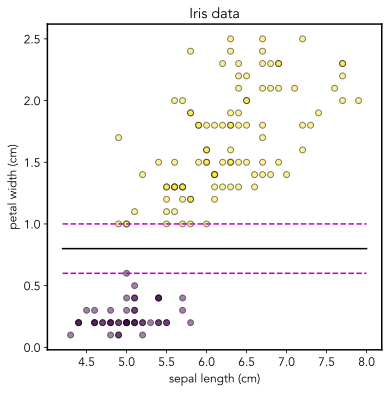

In [275]:
# load the iris data
iris = load_iris()
iris_df = pd.DataFrame(
    data= np.c_[iris["data"], iris["target"]], 
    columns= iris["feature_names"] + ["target"]
)
iris_df['target'].replace(0, -1, inplace=True)
iris_df['target'].replace(2, 1, inplace=True)
y = iris_df.target.values.reshape(-1, 1)
X = iris_df.iloc[:, [0, 3]].values

# fit the SVM
svm = SVM(margin='hard')
y_pred = svm.fit_transform(X, y)

# plot the results
w = svm.w
b = svm.bias
ax = plot_svm(X, y, w, b)
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('petal width (cm)')
ax.set_title('Iris data')
plt.show()

## Soft-margin SVM

### Linearily - separable data

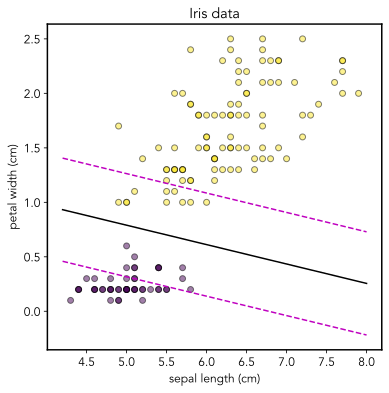

In [276]:
# fit the SVM
svm = SVM(margin='soft', C=100)
y_pred = svm.fit_transform(X, y)

# plot the results
w = svm.w
b = svm.bias
ax = plot_svm(X, y, w, b)
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('petal width (cm)')
ax.set_title('Iris data')
plt.show()

### Not linearily-separable data

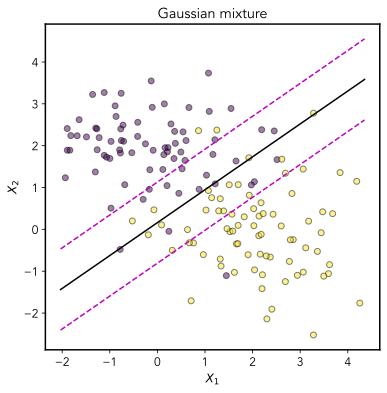

In [277]:
# generate the data
n = 150
X1 = mvn.rvs([0, 2], size=n // 2)
X2 = mvn.rvs([2, 0], size=n // 2)
X = np.concatenate([X1, X2])
y = np.concatenate([np.repeat(-1, n // 2), np.repeat(1, n // 2)]).reshape(-1, 1)

# fit the SVM
svm = SVM(margin='soft', C=100)
y_pred = svm.fit_transform(X, y)

# plot the results
w = svm.w
b = svm.bias
ax = plot_svm(X, y, w, b)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_title('Gaussian mixture')
plt.show()

In [279]:
# create interactive plotly figure
xs = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
fig = plotly_widgets(
    X[:, 0], X[:, 1], xs, title='SVM classifier')
fig.add_scatter()
fig.add_scatter()
fig.data[0].x = fig.data[2].x = fig.data[3].x = xs
@interact(C=(0.1, 100, 0.1))
def update(C=100):
    with fig.batch_update():
        svm = SVM(margin='soft', C=C)
        svm.fit(X, y)
        w = svm.w
        b = svm.bias
        a = -w[0]/w[1]
        yy = a*xs - (b)/w[1]
        margin = 1 / np.sqrt(np.sum(w**2))
        yy_neg = yy - np.sqrt(1 + a**2) * margin
        yy_pos = yy + np.sqrt(1 + a**2) * margin
        fig.data[0].y=yy
        fig.data[2].y=yy_neg
        fig.data[3].y=yy_pos
fig.data[0].line.color = 'black'
fig.data[2].line.color = fig.data[3].line.color = 'violet'
fig.data[2].line.dash = fig.data[3].line.dash = 'dash'
cmap = {-1: 'purple', 1: 'yellow'}
colors = [cmap[i] for i in y.flatten()]
fig.data[1].marker.color = colors
fig.data[1].marker.opacity = 0.5
fig.data[1].marker.size = 8
fig.data[1].marker.line.color = 'black'
fig.data[1].marker.line.width = 1

fig.data[0].name = 'decision boundary'
fig.data[2].name = fig.data[3].name = 'hyperplane'
fig

interactive(children=(FloatSlider(value=100.0, description='C', min=0.1), Output()), _dom_classes=('widget-int…

FigureWidget({
    'data': [{'line': {'color': 'black'},
              'name': 'decision boundary',
          …